***Importazione Librerie***

In [1]:
import numpy as np
import pandas as pd

# Librerie per visualizzazioni
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerie per clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Librerie per preprocessing
from sklearn.preprocessing import StandardScaler

***`Caricamento del dataset`***

Carichiamo il file CSV 'london_weather.csv' (assumiamo separatore ';')
Visualizziamo le prime righe, colonne, tipi di dati e informazioni sul dataset

In [2]:
data = pd.read_csv("london_weather.csv", sep=';')
print("Prime righe del dataset:")
print(data.head())
print("\nColonne del dataset:")
print(data.columns)
print("\nTipi di dati:")
print(data.dtypes)
print("\nInformazioni sul dataset:")
data.info()


Prime righe del dataset:
       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  

Colonne del dataset:
Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'],
      dtype='object')

Tipi di dat

***`Verifica dei valori mancanti`***

Controlliamo la presenza di valori nulli per ogni colonna



In [5]:
print("\nValori mancanti per colonna:")
print(data.isnull().sum())




Valori mancanti per colonna:
date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


***`Gestione dei valori mancanti`***

Riempiamo i valori nulli nelle colonne numeriche con la loro media
Colonne interessate: cloud_cover, sunshine, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth



In [6]:
columns_to_fill = [
    "cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp",
    "min_temp", "precipitation", "pressure", "snow_depth"
]
for col in columns_to_fill:
    data[col] = data[col].fillna(data[col].mean())
print("\nValori mancanti dopo il riempimento:")
print(data.isnull().sum())



Valori mancanti dopo il riempimento:
date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64


***`Conversione della colonna 'date`'***

Convertiamo la colonna 'date' in formato datetime per analisi temporali


In [7]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')


***`Visualizzazioni esplorative: Pairplot`***

Creiamo un pairplot per esplorare le relazioni tra tutte le variabili numeriche

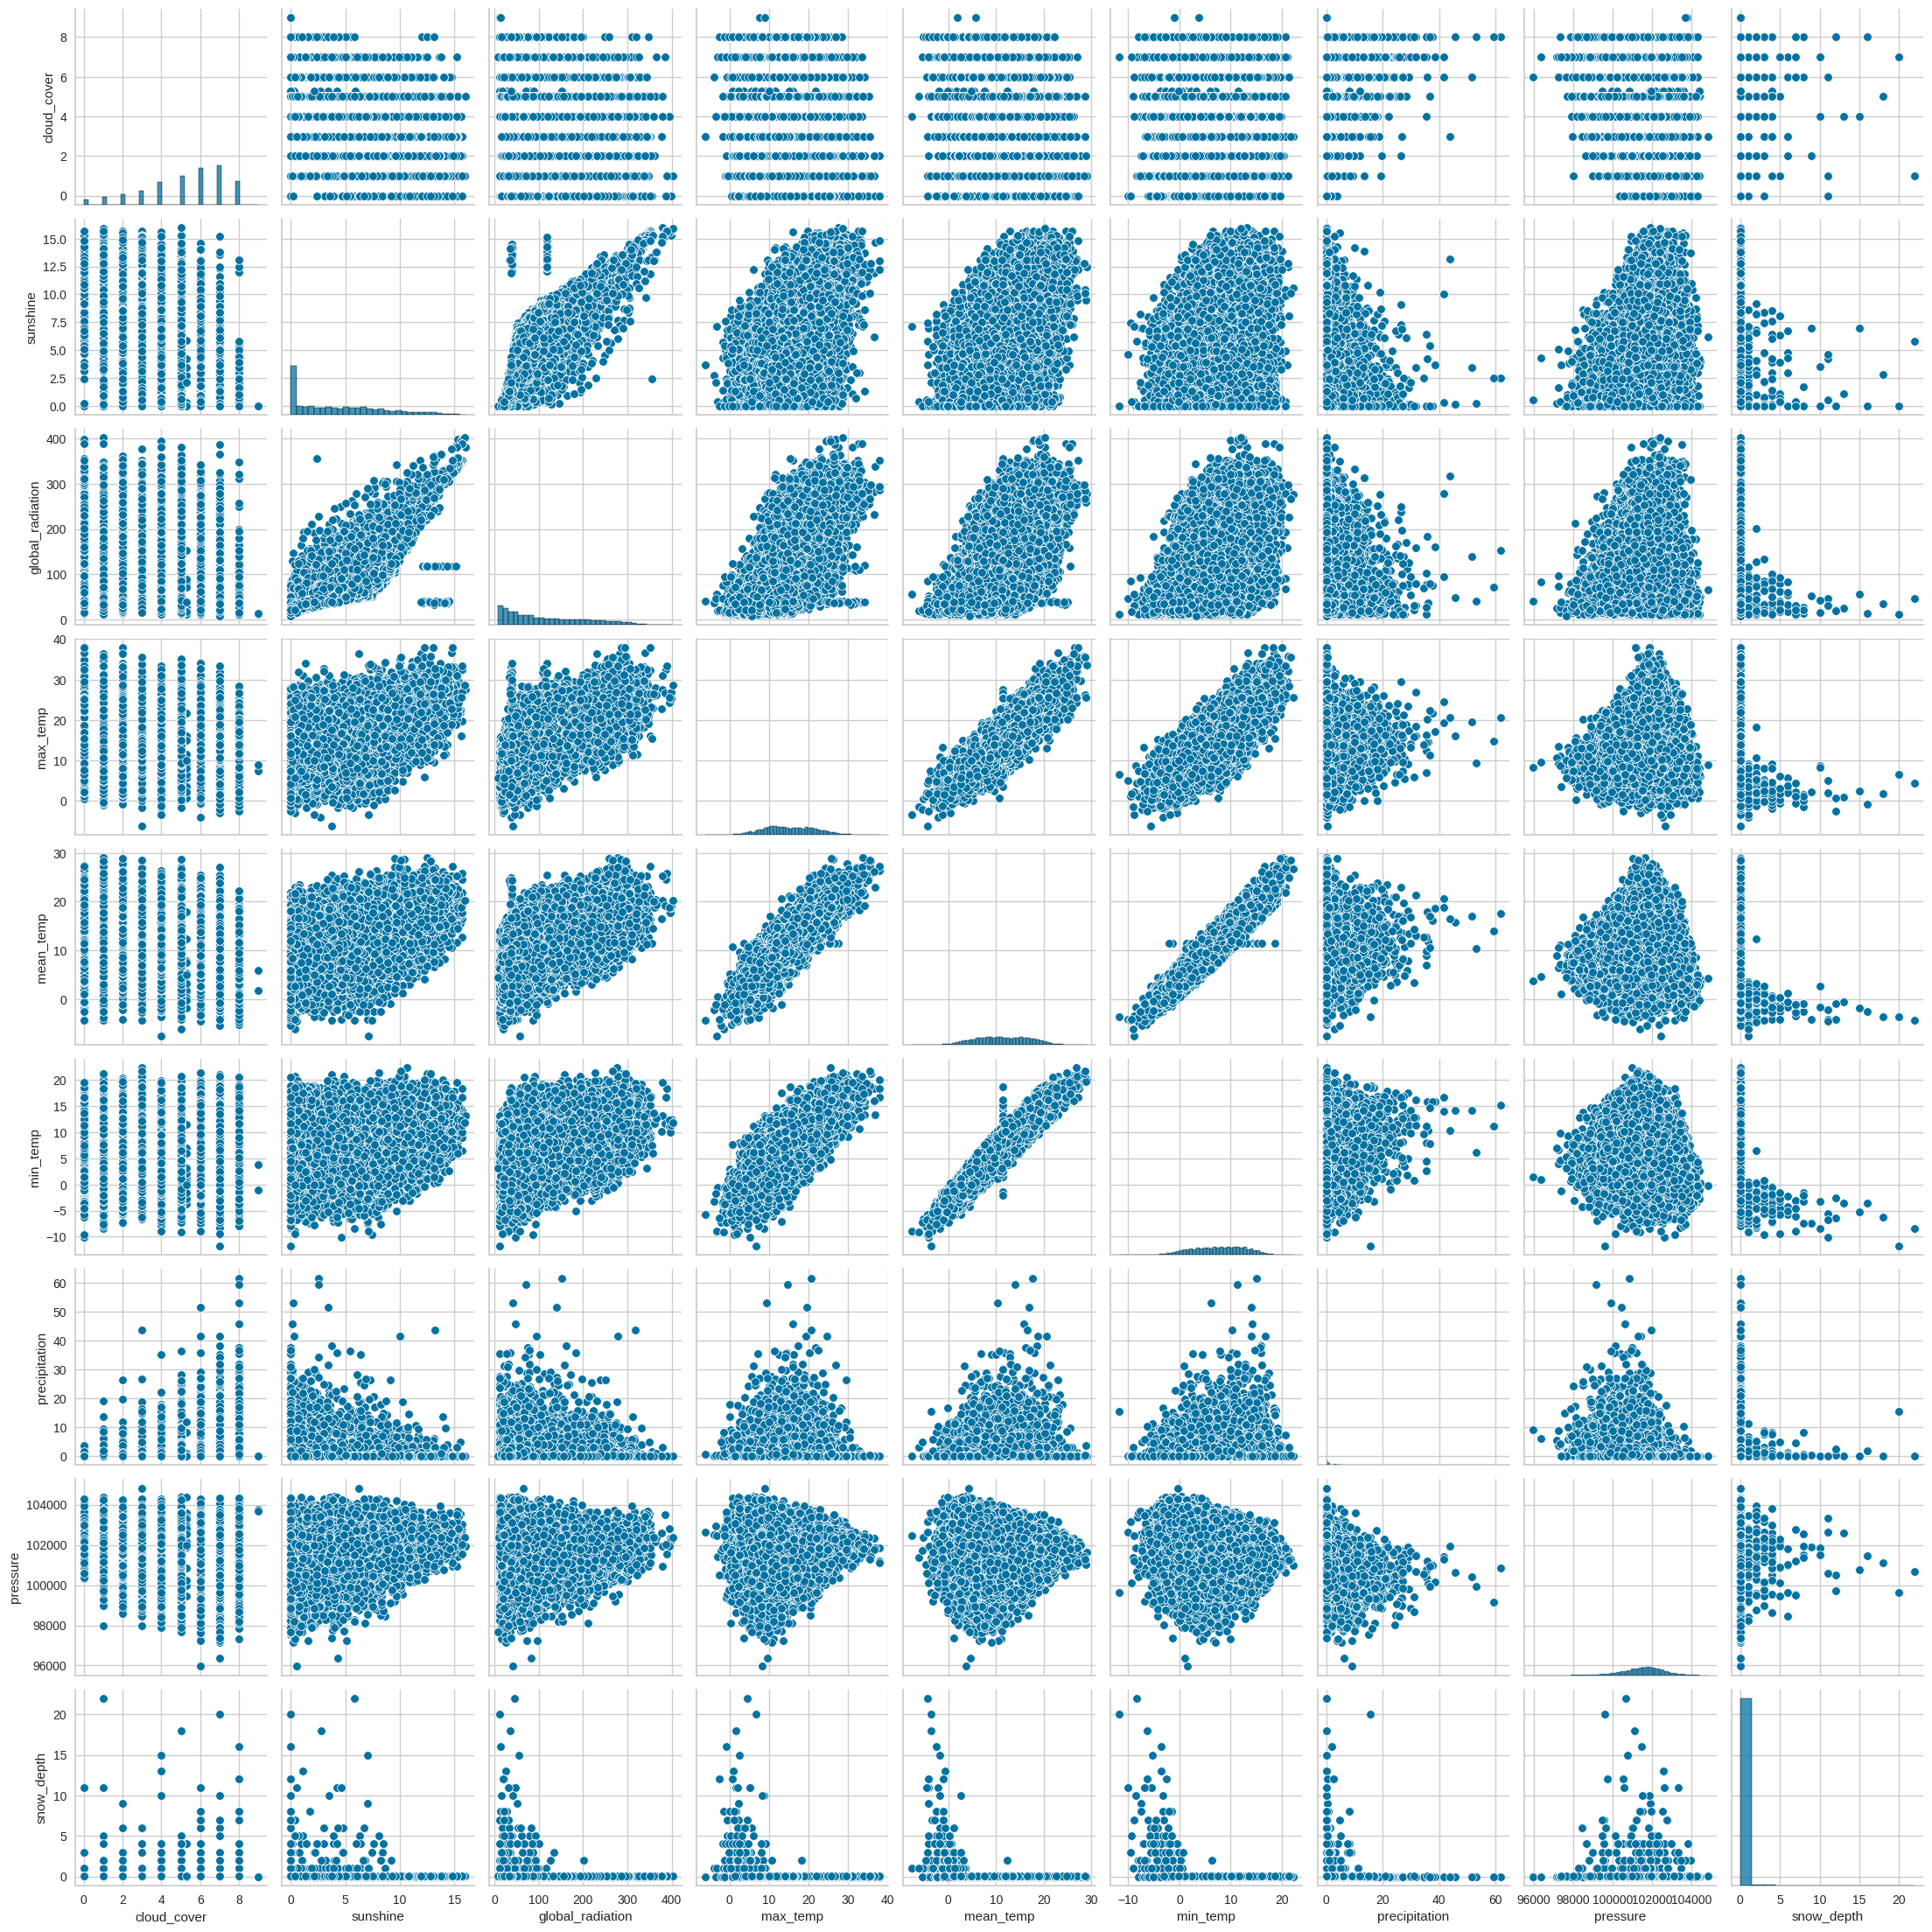

In [8]:
sns.pairplot(data)
plt.show()

***`Visualizzazioni esplorative: Heatmap`***

Creiamo una heatmap per visualizzare le correlazioni tra variabili numeriche
i

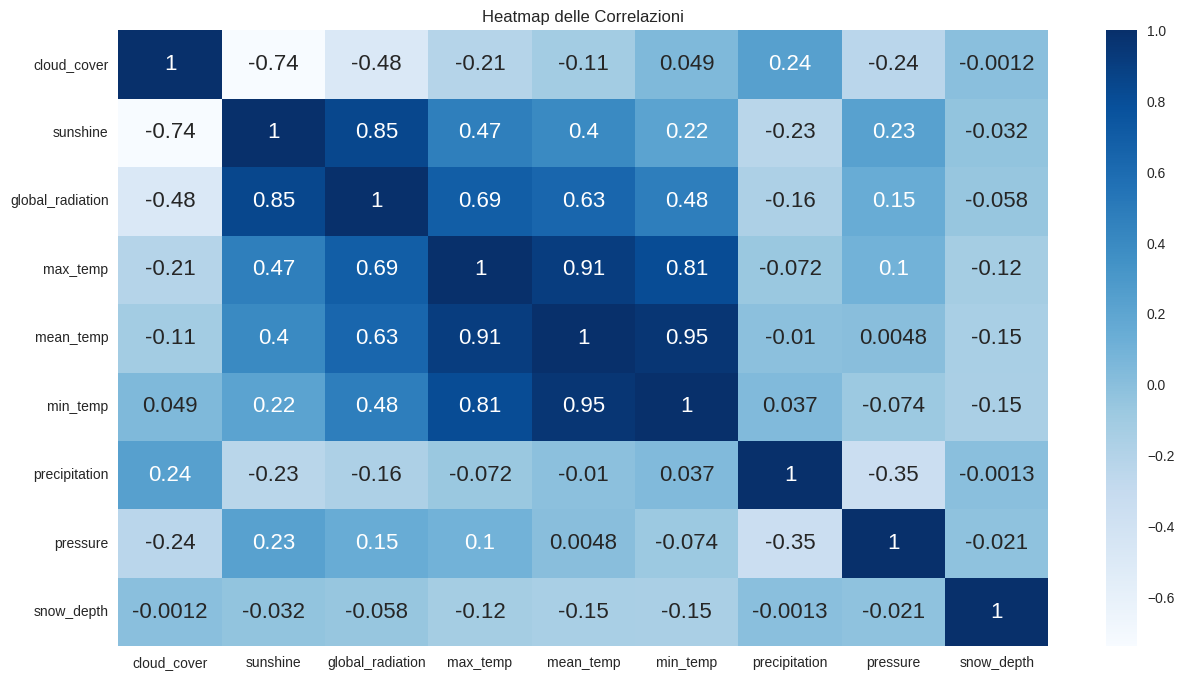

In [9]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(numeric_only=True), cmap='Blues', annot=True, annot_kws={"fontsize":16})
plt.title('Heatmap delle Correlazioni')
plt.show()

#  `Clustering delle Temperature `

Selezione delle feature per il clustering delle temperature

Usiamo max_temp, mean_temp e min_temp per un'analisi più completa

Verifichiamo la forma dei dati

In [10]:
x_temp = data[['max_temp', 'mean_temp', 'min_temp']].values
print("\nForma dei dati per il clustering delle temperature:", x_temp.shape)


Forma dei dati per il clustering delle temperature: (15341, 3)


***`Standardizzazione dei dati`***

Applichiamo StandardScaler per uniformare la scala delle variabili, essenziale per K-Means e altri algoritmi

In [11]:
scaler_temp = StandardScaler()
x_temp_scaled = scaler_temp.fit_transform(x_temp)


***`Metodo del gomito per determinare il numero ottimale di cluster`***

Calcoliamo il WCSS e il Silhouette Score per un intervallo di cluster (2-10)

Questo aiuta a scegliere il numero ottimale di cluster

In [12]:
wcss_temp = []
sil_scores_temp = []
for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(x_temp_scaled)
    wcss_temp.append(km.inertia_)
    labels = km.labels_
    sil_scores_temp.append(silhouette_score(x_temp_scaled, labels))

***`Visualizzazione del metodo del gomito`***

Plottiamo il WCSS per identificare il "gomito"

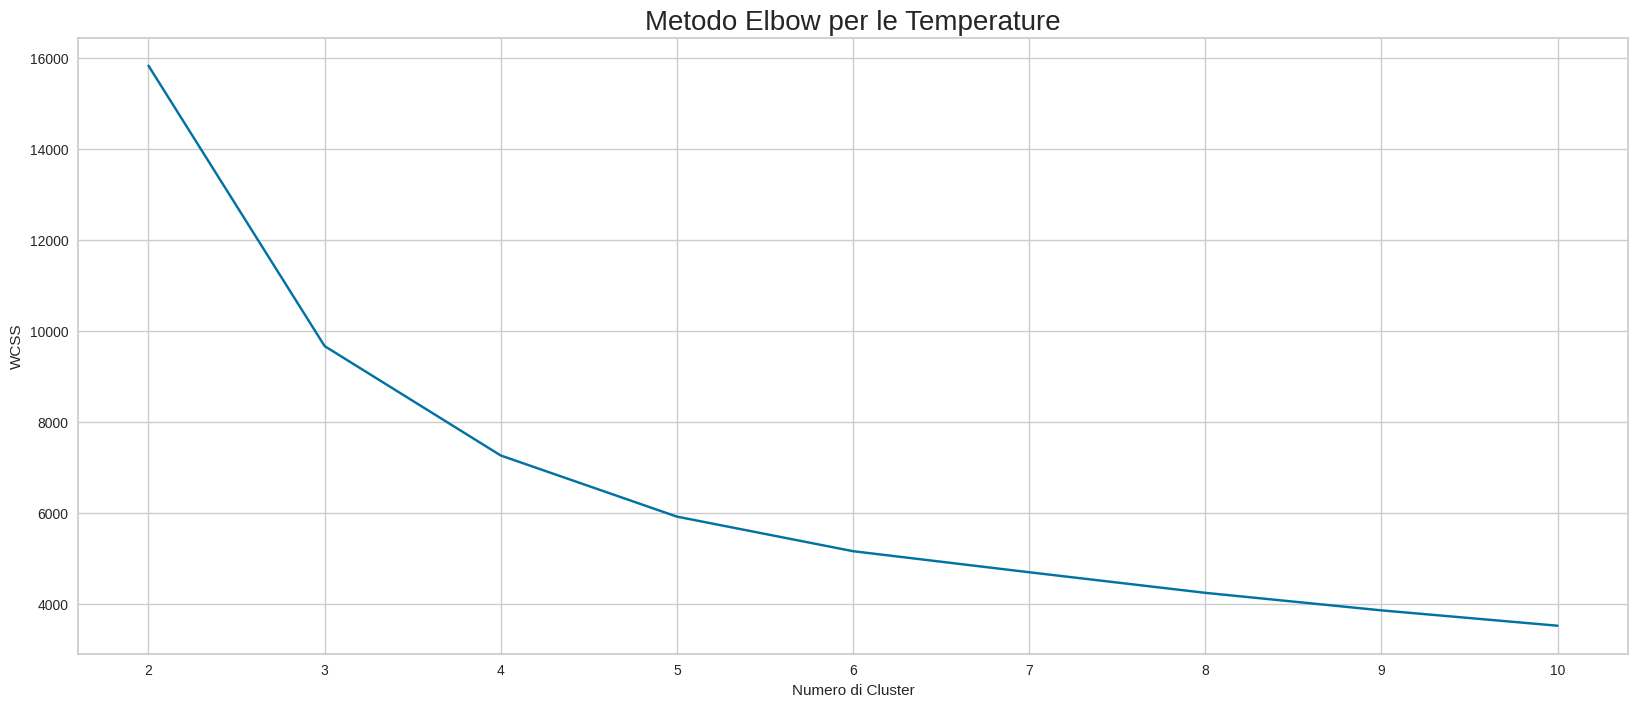

In [15]:
plt.figure(figsize=(20,8))
plt.plot(range(2, 11), wcss_temp)
plt.title('Metodo Elbow per le Temperature', fontsize=20)
plt.xlabel('Numero di Cluster')
plt.ylabel('WCSS')
plt.show()


***`Visualizzazione del Silhouette Score`***

Plottiamo il Silhouette Score per confermare il numero ottimale di cluster

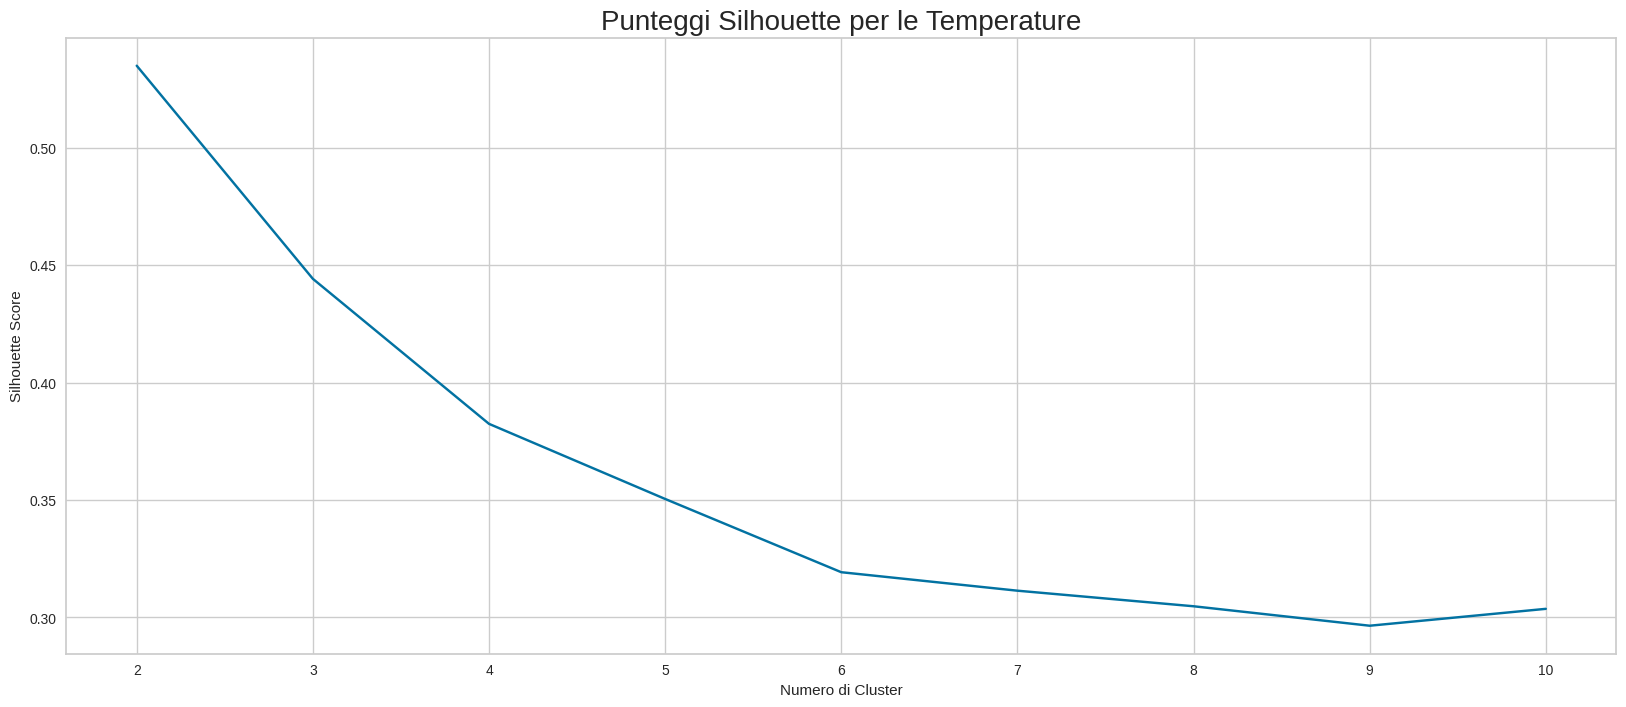

In [16]:
plt.figure(figsize=(20,8))
plt.plot(range(2, 11), sil_scores_temp)
plt.title('Punteggi Silhouette per le Temperature', fontsize=20)
plt.xlabel('Numero di Cluster')
plt.ylabel('Silhouette Score')
plt.show()


***`K-Means Clustering`***

Applichiamo K-Means con 4 cluster (scelta basata su Elbow/Silhouette)

Usiamo dati standardizzati per risultati più accurati

In [17]:
km_temp = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means_temp = km_temp.fit_predict(x_temp_scaled)


**`*Visualizzazione dei cluster di temperature*`**

Plottiamo i cluster con trasparenza (alpha=0.6) per gestire la sovrapposizione

Aggiungiamo i centroidi e etichette descrittive

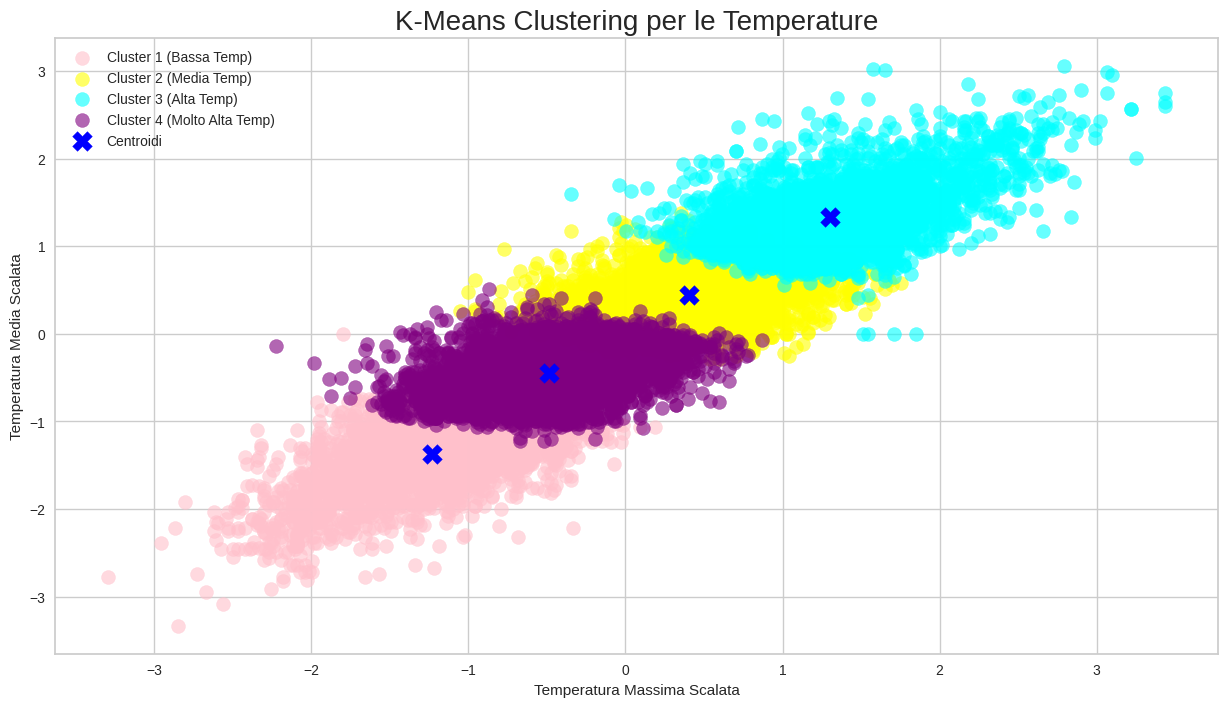

In [18]:
plt.figure(figsize=(15, 8))
colors = ['pink', 'yellow', 'cyan', 'purple']
labels_desc = ['Cluster 1 (Bassa Temp)', 'Cluster 2 (Media Temp)', 'Cluster 3 (Alta Temp)', 'Cluster 4 (Molto Alta Temp)']
for i in range(4):
    plt.scatter(x_temp_scaled[y_means_temp == i, 0], x_temp_scaled[y_means_temp == i, 1],
                s=100, c=colors[i], label=labels_desc[i], alpha=0.6)
plt.scatter(km_temp.cluster_centers_[:, 0], km_temp.cluster_centers_[:, 1], s=200, c='blue', label='Centroidi', marker='X')
plt.title('K-Means Clustering per le Temperature', fontsize=20)
plt.xlabel('Temperatura Massima Scalata')
plt.ylabel('Temperatura Media Scalata')
plt.legend()
plt.show()

***`Visualizzazione dei centroidi in scala originale`***

Trasformiamo i centroidi in scala originale per interpretabilità

In [19]:
print("\nCentroidi dei cluster (scala originale - max_temp, mean_temp, min_temp):")
print(scaler_temp.inverse_transform(km_temp.cluster_centers_))


Centroidi dei cluster (scala originale - max_temp, mean_temp, min_temp):
[[ 7.32151088  3.60079242  0.15761844]
 [18.0553802  14.0468475  10.04395474]
 [23.94273785 19.09671997 14.18443185]
 [12.18101767  8.90265006  5.47149047]]


***`Silhouette Visualizer`***

Usiamo SilhouetteVisualizer per valutare la qualità dei cluster


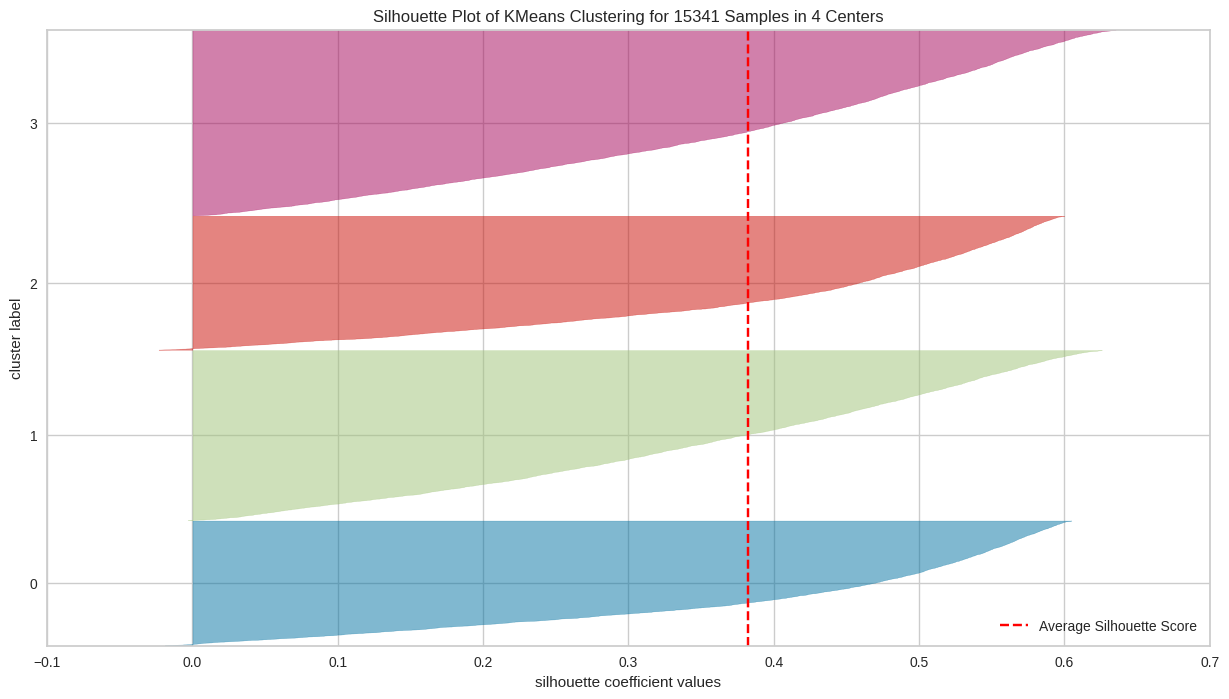

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15341 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
visualizer_temp = SilhouetteVisualizer(km_temp, colors='yellowbrick')
plt.figure(figsize=(15,8))
visualizer_temp.fit(x_temp_scaled)
visualizer_temp.show()

***`Metriche di valutazione per K-Means`***

Calcoliamo Silhouette Score e Davies-Bouldin Score per quantificare la qualità dei cluster


In [21]:
km_sil_temp = silhouette_score(x_temp_scaled, y_means_temp)
km_db_temp = davies_bouldin_score(x_temp_scaled, y_means_temp)
print(f"K-Means Silhouette Score (Temperature): {km_sil_temp}")
print(f"K-Means Davies-Bouldin Score (Temperature): {km_db_temp}")


K-Means Silhouette Score (Temperature): 0.38245996865467896
K-Means Davies-Bouldin Score (Temperature): 0.8280581662698623


***`Agglomerative Clustering`***

Applichiamo il clustering gerarchico con linkage 'ward' e 4 cluster

Visualizziamo i risultati con gli stessi colori per confronto



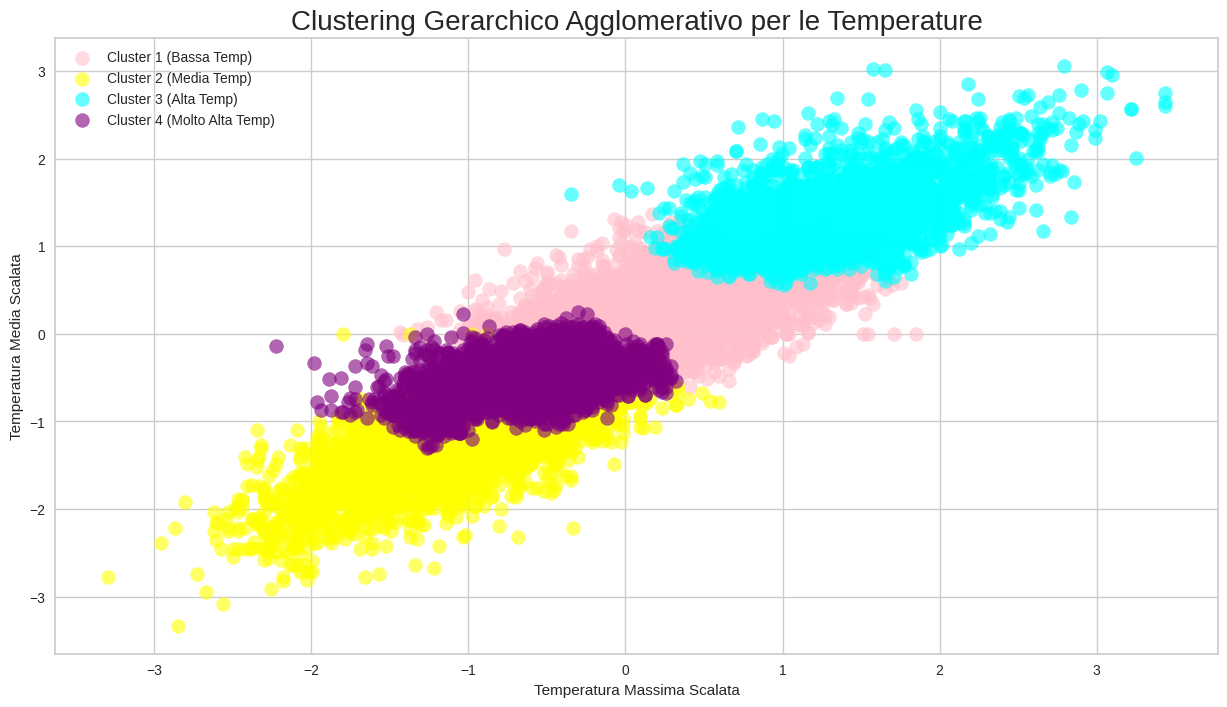

In [22]:
hc_temp = AgglomerativeClustering(n_clusters=4, linkage='ward')
y_hc_temp = hc_temp.fit_predict(x_temp_scaled)
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.scatter(x_temp_scaled[y_hc_temp == i, 0], x_temp_scaled[y_hc_temp == i, 1],
                s=100, c=colors[i], label=labels_desc[i], alpha=0.6)
plt.title('Clustering Gerarchico Agglomerativo per le Temperature', fontsize=20)
plt.xlabel('Temperatura Massima Scalata')
plt.ylabel('Temperatura Media Scalata')
plt.legend()
plt.show()


***`Metriche per Agglomerative Clustering`***

Calcoliamo Silhouette Score e Davies-Bouldin Score per confronto con K-Means


In [23]:
hc_sil_temp = silhouette_score(x_temp_scaled, y_hc_temp)
hc_db_temp = davies_bouldin_score(x_temp_scaled, y_hc_temp)
print(f"Agglomerative Silhouette Score (Temperature): {hc_sil_temp}")
print(f"Agglomerative Davies-Bouldin Score (Temperature): {hc_db_temp}")

Agglomerative Silhouette Score (Temperature): 0.3477951286152506
Agglomerative Davies-Bouldin Score (Temperature): 0.8588921650486909


***`Analisi descrittiva dei cluster`***

Aggiungiamo le etichette dei cluster al dataset e calcoliamo statistiche descrittive


In [24]:
data['cluster_temp'] = y_means_temp
print("\nStatistiche descrittive per cluster (Temperature):")
for i in range(4):
    print(f"\nCluster {i}:")
    print(data[data['cluster_temp'] == i][['max_temp', 'mean_temp', 'min_temp']].describe())


Statistiche descrittive per cluster (Temperature):

Cluster 0:
          max_temp    mean_temp     min_temp
count  3118.000000  3118.000000  3118.000000
mean      7.315811     3.595566     0.153207
std       3.170463     2.199709     2.397533
min      -6.200000    -7.600000   -11.800000
25%       5.100000     2.400000    -1.300000
50%       7.500000     4.000000     0.500000
75%       9.600000     5.200000     1.800000
max      16.600000    11.475511     6.300000

Cluster 1:
          max_temp    mean_temp     min_temp
count  4249.000000  4249.000000  4249.000000
mean     18.064499    14.052555    10.049146
std       2.735982     1.662518     2.030498
min       8.500000     9.800000     3.200000
25%      16.200000    12.800000     8.700000
50%      18.100000    14.000000    10.100000
75%      19.900000    15.400000    11.500000
max      26.900000    19.400000    18.700000

Cluster 2:
          max_temp    mean_temp     min_temp
count  3347.000000  3347.000000  3347.000000
mean     23.

# `Clustering su Radiazione Solare e Precipitazioni`

***`Selezione delle feature per il clustering`***

Usiamo global_radiation e precipitation come nel codice originale

Verifichiamo la forma dei dati


In [25]:
x_precip_rad = data[['global_radiation', 'precipitation']].values
print("\nForma dei dati per il clustering di radiazione e precipitazioni:", x_precip_rad.shape)


Forma dei dati per il clustering di radiazione e precipitazioni: (15341, 2)


*`Standardizzazione dei dati`*

Standardizziamo per uniformare la scala
(global_radiation ha valori molto più grandi di precipitation)


In [26]:
scaler_precip_rad = StandardScaler()
x_precip_rad_scaled = scaler_precip_rad.fit_transform(x_precip_rad)

***`Metodo Elbow per radiazione e precipitazioni`***

Calcoliamo WCSS e Silhouette Score per scegliere il numero ottimale di cluster



In [27]:
wcss_precip_rad = []
sil_scores_precip_rad = []
for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(x_precip_rad_scaled)
    wcss_precip_rad.append(km.inertia_)
    labels = km.labels_
    sil_scores_precip_rad.append(silhouette_score(x_precip_rad_scaled, labels))


***`Visualizzazione del metodo Elbow`***


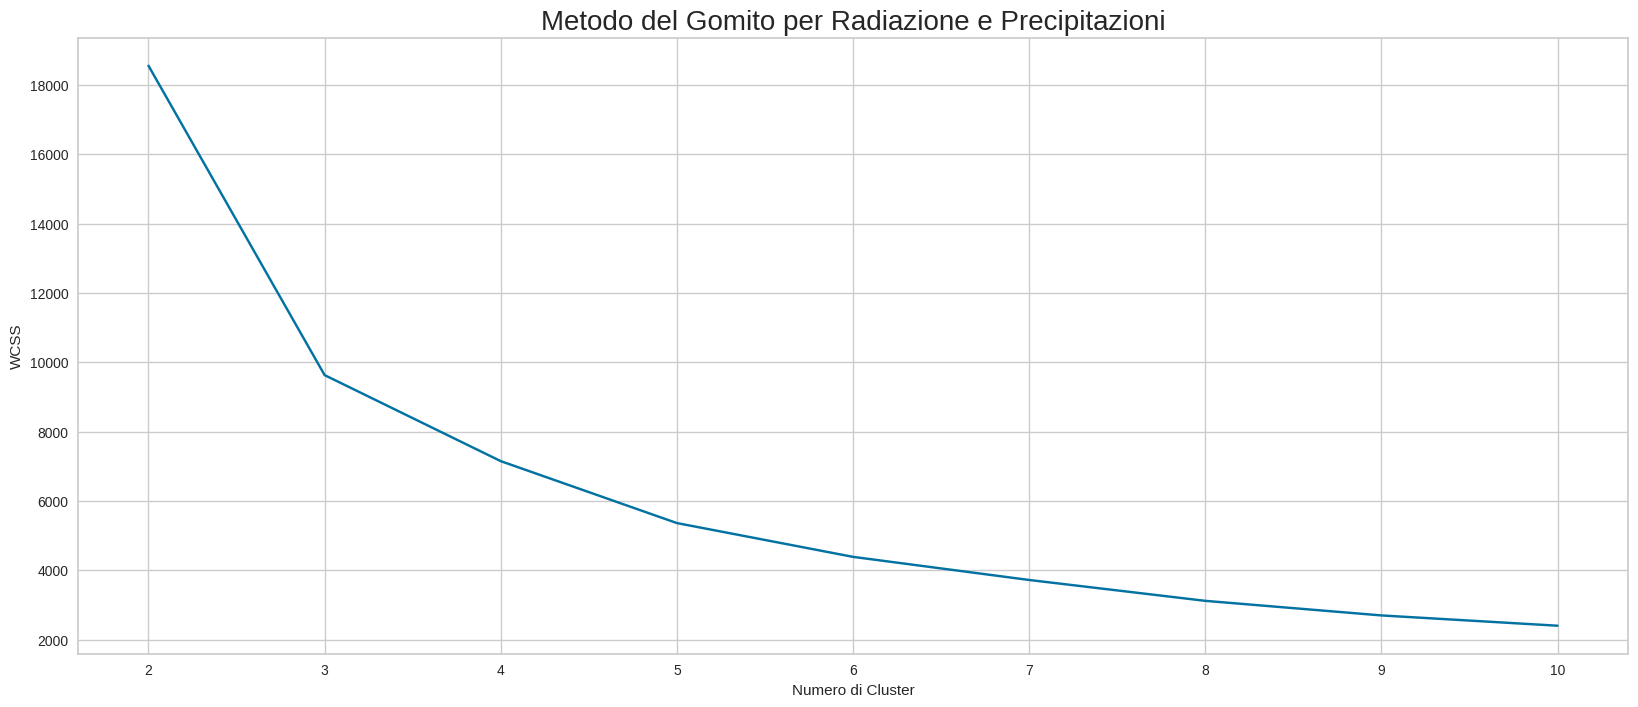

In [28]:
plt.figure(figsize=(20,8))
plt.plot(range(2, 11), wcss_precip_rad)
plt.title('Metodo del Gomito per Radiazione e Precipitazioni', fontsize=20)
plt.xlabel('Numero di Cluster')
plt.ylabel('WCSS')
plt.show()

***`Visualizzazione del Silhouette Score`***


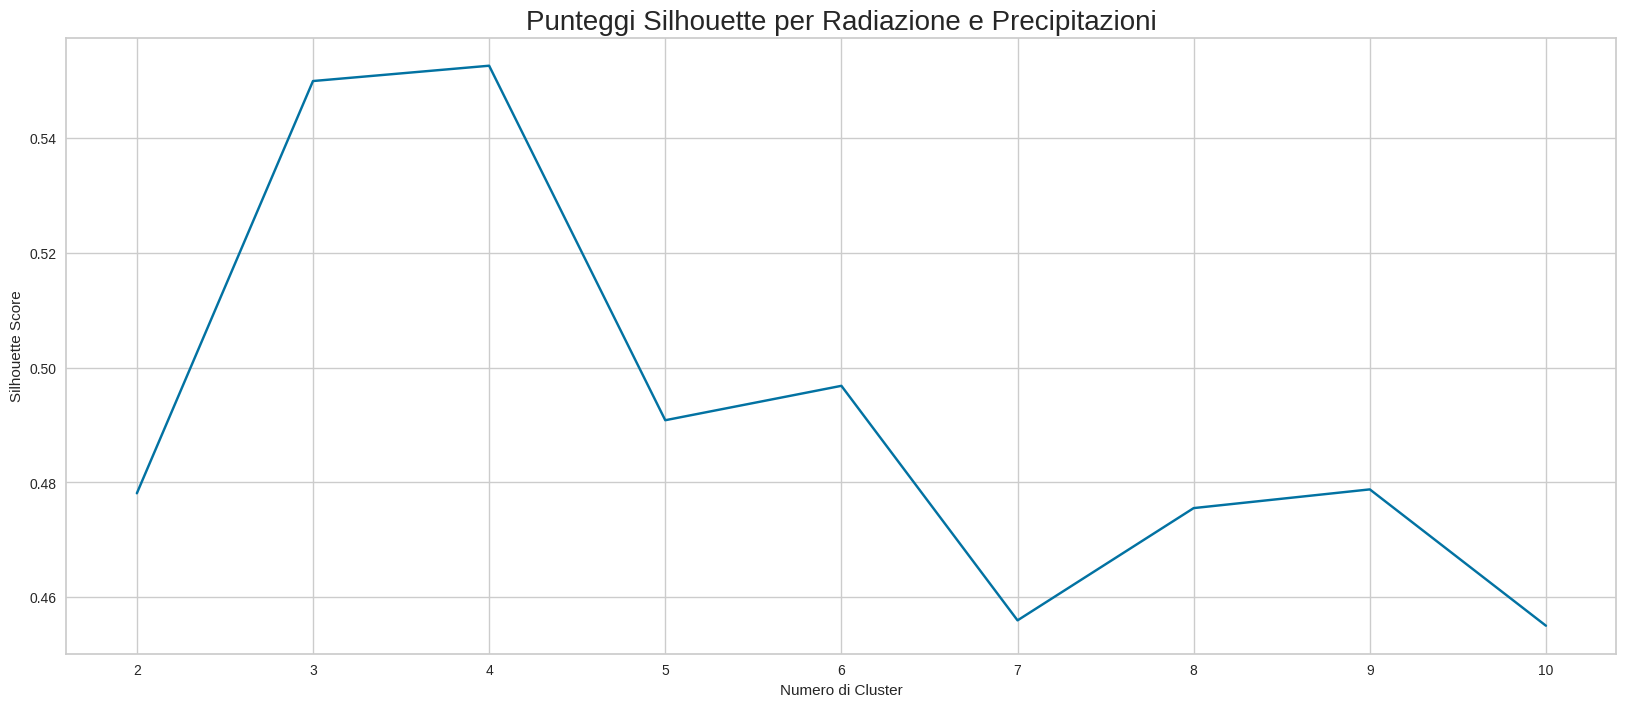

In [29]:
plt.figure(figsize=(20,8))
plt.plot(range(2, 11), sil_scores_precip_rad)
plt.title('Punteggi Silhouette per Radiazione e Precipitazioni', fontsize=20)
plt.xlabel('Numero di Cluster')
plt.ylabel('Silhouette Score')
plt.show()

***`K-Means Clustering`***

Applichiamo K-Means con 4 cluster


In [30]:
km_precip_rad = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means_precip_rad = km_precip_rad.fit_predict(x_precip_rad_scaled)

***`Visualizzazione dei cluster`***

Plottiamo i cluster con trasparenza e centroidi


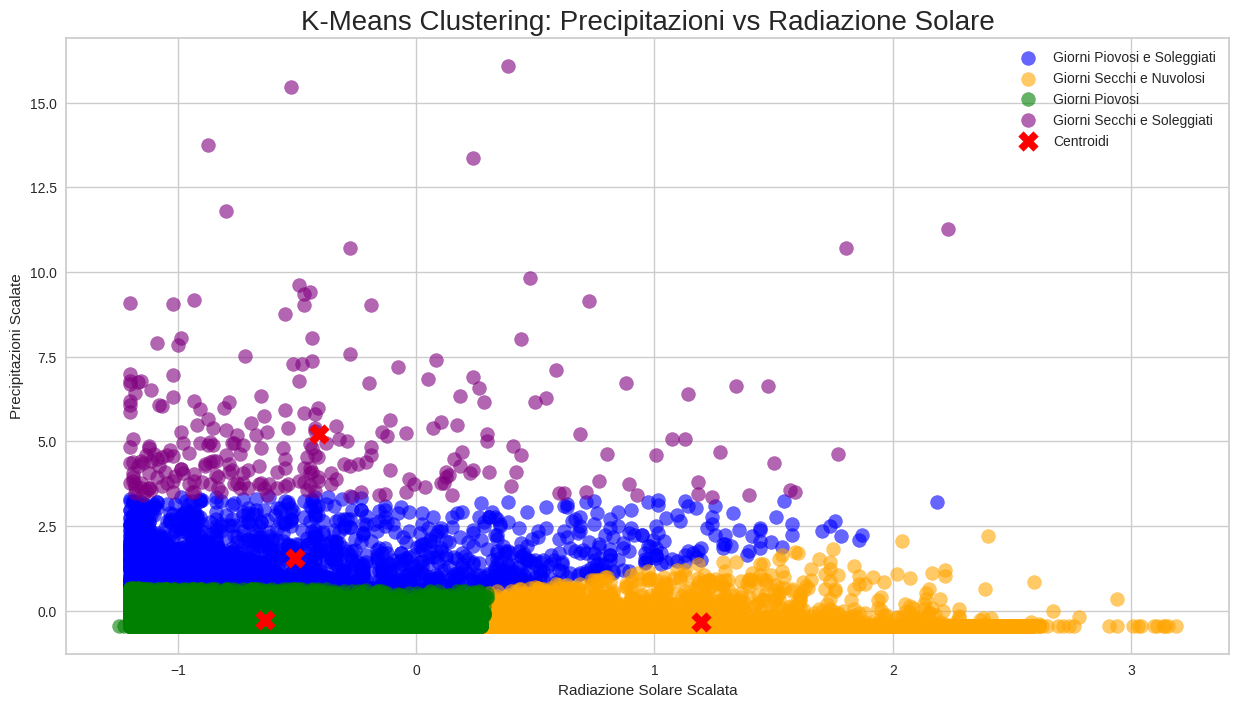

In [31]:
plt.figure(figsize=(15, 8))
colors_precip_rad = ['blue', 'orange', 'green', 'purple']
labels_precip_rad = ['Giorni Piovosi e Soleggiati', 'Giorni Secchi e Nuvolosi', 'Giorni Piovosi', 'Giorni Secchi e Soleggiati']
for i in range(4):
    plt.scatter(x_precip_rad_scaled[y_means_precip_rad == i, 0], x_precip_rad_scaled[y_means_precip_rad == i, 1],
                s=100, c=colors_precip_rad[i], label=labels_precip_rad[i], alpha=0.6)
plt.scatter(km_precip_rad.cluster_centers_[:, 0], km_precip_rad.cluster_centers_[:, 1], s=200, c='red', label='Centroidi', marker='X')
plt.title('K-Means Clustering: Precipitazioni vs Radiazione Solare', fontsize=20)
plt.xlabel('Radiazione Solare Scalata')
plt.ylabel('Precipitazioni Scalate')
plt.legend()
plt.show()

In [32]:
# Centroidi in scala originale
print("\nCentroidi dei cluster (scala originale - global_radiation, precipitation):")
print(scaler_precip_rad.inverse_transform(km_precip_rad.cluster_centers_))


Centroidi dei cluster (scala originale - global_radiation, precipitation):
[[ 73.55930233   7.49389535]
 [224.79218266   0.43628817]
 [ 62.5123102    0.61017383]
 [ 82.6124031   21.13914729]]


***`Silhouette Visualizer`***


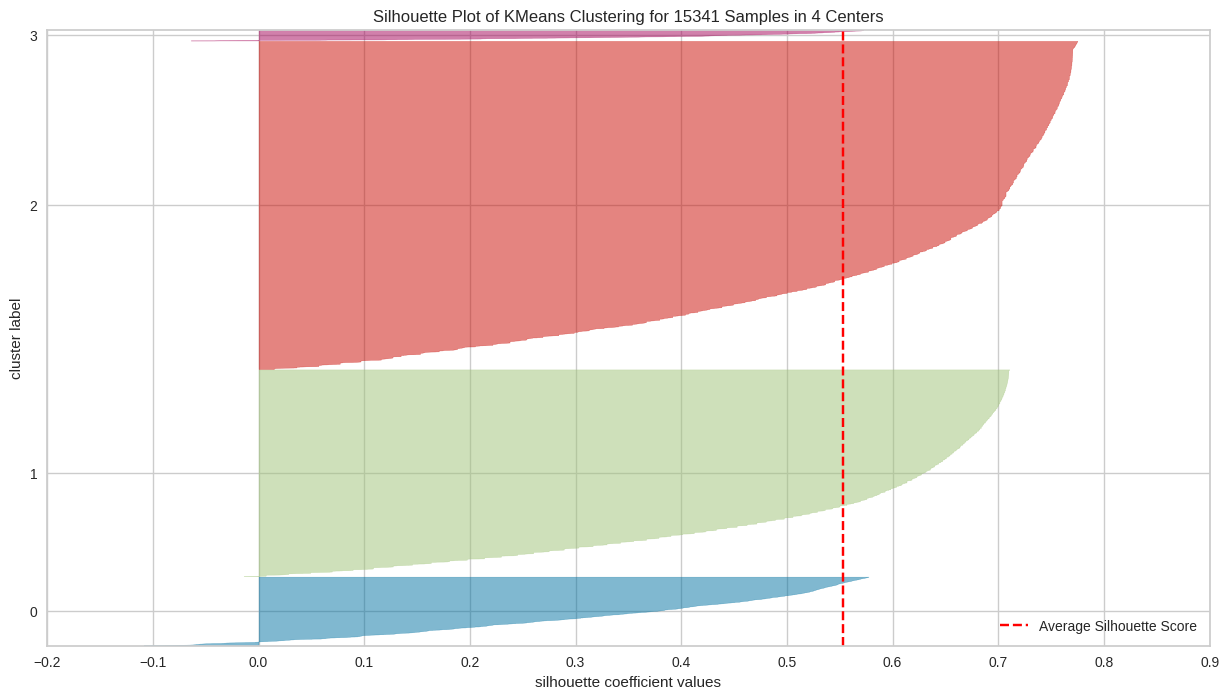

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15341 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
visualizer_precip_rad = SilhouetteVisualizer(km_precip_rad, colors='yellowbrick')
plt.figure(figsize=(15,8))
visualizer_precip_rad.fit(x_precip_rad_scaled)
visualizer_precip_rad.show()

***`Metriche di valutazione`***




In [34]:
km_sil_precip_rad = silhouette_score(x_precip_rad_scaled, y_means_precip_rad)
km_db_precip_rad = davies_bouldin_score(x_precip_rad_scaled, y_means_precip_rad)
print(f"K-Means Silhouette Score (Precip/Rad): {km_sil_precip_rad}")
print(f"K-Means Davies-Bouldin Score (Precip/Rad): {km_db_precip_rad}")

K-Means Silhouette Score (Precip/Rad): 0.5526031170385841
K-Means Davies-Bouldin Score (Precip/Rad): 0.6697665522496482


***`Agglomerative Clustering`***

Applichiamo il clustering gerarchico con linkage 'ward'


In [35]:
hc_precip_rad = AgglomerativeClustering(n_clusters=4, linkage='ward')
y_hc_precip_rad = hc_precip_rad.fit_predict(x_precip_rad_scaled)

***`Visualizzazione dei cluster`***



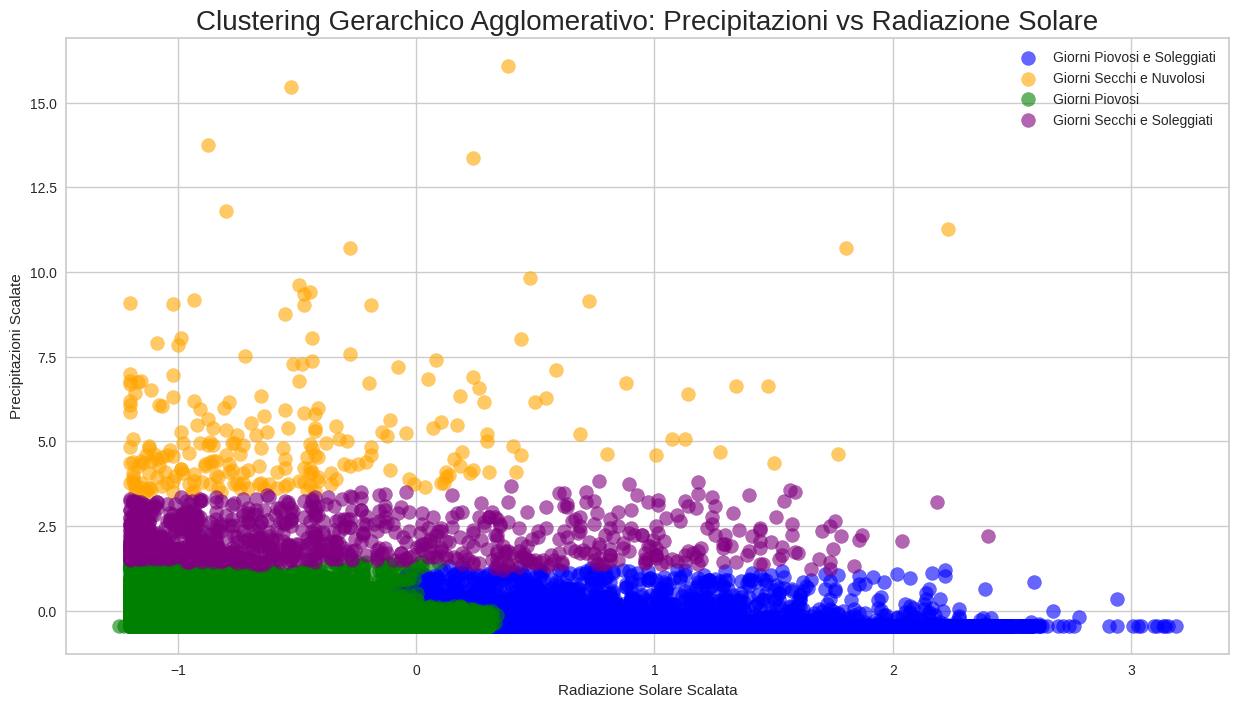

In [36]:
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.scatter(x_precip_rad_scaled[y_hc_precip_rad == i, 0], x_precip_rad_scaled[y_hc_precip_rad == i, 1],
                s=100, c=colors_precip_rad[i], label=labels_precip_rad[i], alpha=0.6)
plt.title('Clustering Gerarchico Agglomerativo: Precipitazioni vs Radiazione Solare', fontsize=20)
plt.xlabel('Radiazione Solare Scalata')
plt.ylabel('Precipitazioni Scalate')
plt.legend()
plt.show()


In [37]:
# Metriche per Agglomerative Clustering
hc_sil_precip_rad = silhouette_score(x_precip_rad_scaled, y_hc_precip_rad)
hc_db_precip_rad = davies_bouldin_score(x_precip_rad_scaled, y_hc_precip_rad)
print(f"Agglomerative Silhouette Score (Precip/Rad): {hc_sil_precip_rad}")
print(f"Agglomerative Davies-Bouldin Score (Precip/Rad): {hc_db_precip_rad}")

Agglomerative Silhouette Score (Precip/Rad): 0.5359573122546402
Agglomerative Davies-Bouldin Score (Precip/Rad): 0.7053250313534998


***`Analisi descrittiva dei cluster`***

Aggiungiamo le etichette dei cluster e calcoliamo statistiche descrittive


In [38]:
data['cluster_precip_rad'] = y_means_precip_rad
print("\nStatistiche descrittive per cluster (Radiazione/Precipitazioni):")
for i in range(4):
    print(f"\nCluster {i}:")
    print(data[data['cluster_precip_rad'] == i][['global_radiation', 'precipitation']].describe())


Statistiche descrittive per cluster (Radiazione/Precipitazioni):

Cluster 0:
       global_radiation  precipitation
count        1717.00000    1717.000000
mean           73.62085       7.499767
std            58.38838       2.640464
min            12.00000       4.000000
25%            26.00000       5.300000
50%            55.00000       7.000000
75%           106.00000       9.200000
max           313.00000      14.200000

Cluster 1:
       global_radiation  precipitation
count       5168.000000    5168.000000
mean         224.792183       0.436288
std           52.395429       1.089489
min          144.000000       0.000000
25%          181.000000       0.000000
50%          218.000000       0.000000
75%          263.000000       0.200000
max          402.000000       9.900000

Cluster 2:
       global_radiation  precipitation
count       8198.000000    8198.000000
mean          62.503462       0.611463
std           38.462276       1.008921
min            8.000000       0.000000
2

#  ***`PCA e DBSCAN `***

***`PCA per ridurre la dimensionalità`***

Applichiamo PCA per visualizzare i cluster di radiazione/precipitazioni in 2D
Calcoliamo la varianza spiegata per valutare la qualità della riduzione


In [39]:
pca = PCA(n_components=2, svd_solver="auto").fit(x_precip_rad_scaled)
pca_x = pca.transform(x_precip_rad_scaled)
print("\nVarianza spiegata dalle componenti PCA:", pca.explained_variance_ratio_)
print("Varianza totale spiegata:", sum(pca.explained_variance_ratio_))


Varianza spiegata dalle componenti PCA: [0.58129491 0.41870509]
Varianza totale spiegata: 1.0


***`K-Means su dati PCA`***

Applichiamo K-Means sui dati originali ma visualizziamo i risultati su PCA


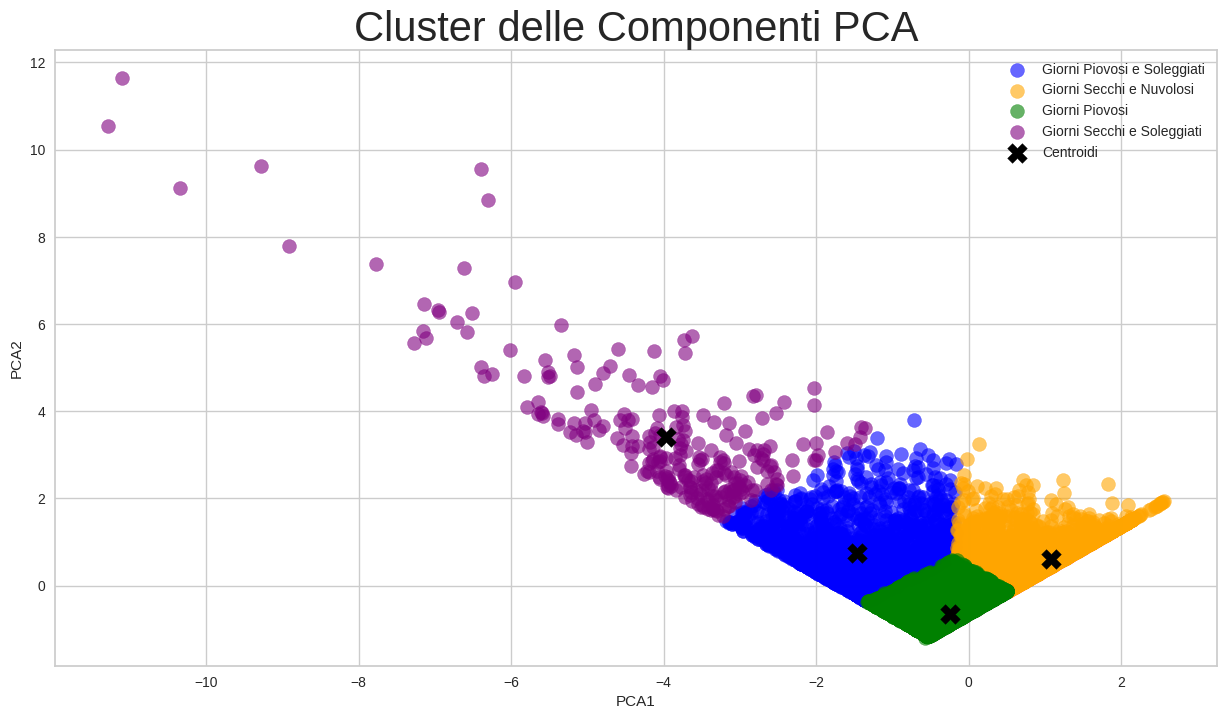

In [41]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means_pca = kmeans_pca.fit_predict(x_precip_rad_scaled)



# Visualizzazione dei cluster su PCA
plt.figure(figsize=(15,8))
plt.title('Cluster delle Componenti PCA', fontsize=30)
for i in range(4):
    plt.scatter(pca_x[y_means_pca == i, 0], pca_x[y_means_pca == i, 1],
                s=100, c=colors_precip_rad[i], label=labels_precip_rad[i], alpha=0.6)
centers_pca = pca.transform(kmeans_pca.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='black', label='Centroidi', marker='X')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


***`Silhouette Visualizer per PCA`***


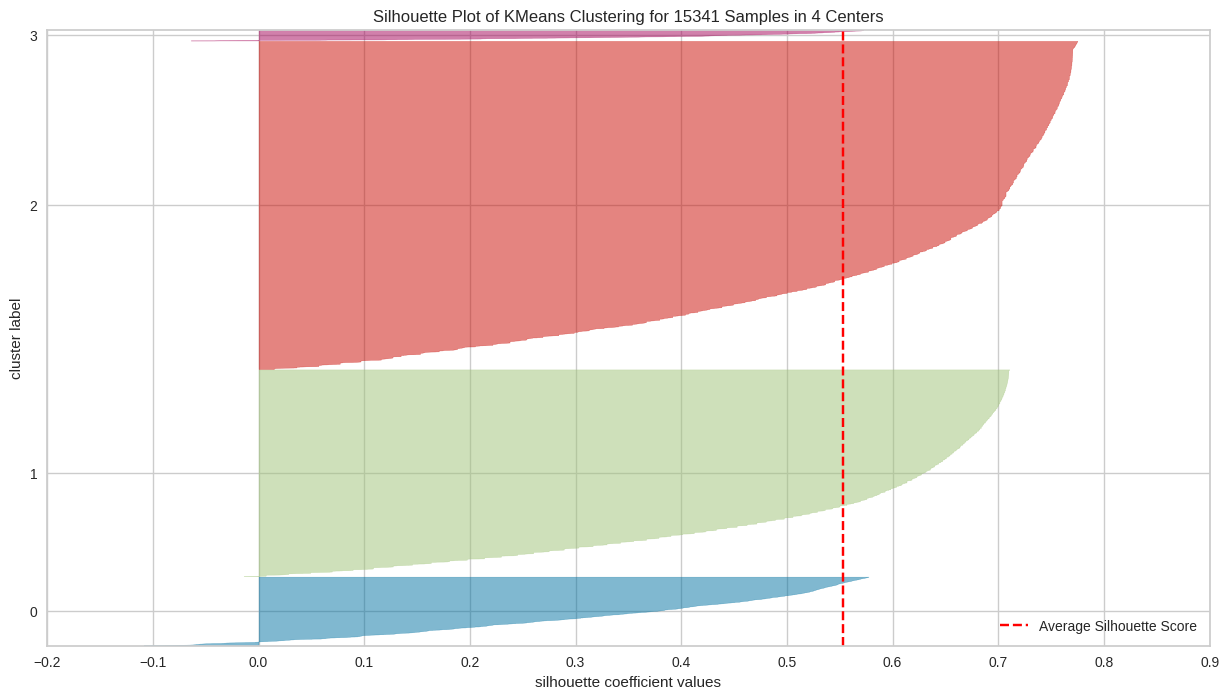

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15341 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [42]:
visualizer_pca = SilhouetteVisualizer(kmeans_pca, colors='yellowbrick')
plt.figure(figsize=(15,8))
visualizer_pca.fit(x_precip_rad_scaled)
visualizer_pca.show()

***`Selezione di eps per DBSCAN`***

Usiamo NearestNeighbors per calcolare le distanze e scegliere un eps ottimale


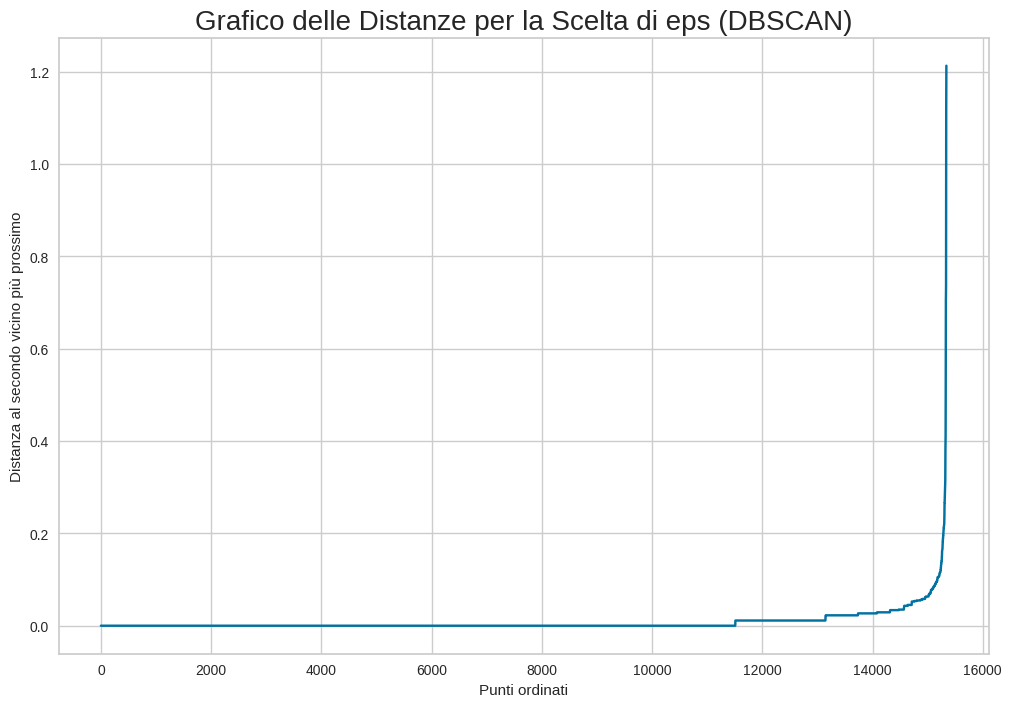

In [43]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(x_precip_rad_scaled)
distances, indices = nbrs.kneighbors(x_precip_rad_scaled)
distances = np.sort(distances, axis=0)[:, 1]
plt.figure(figsize=(12,8))
plt.plot(distances)
plt.title('Grafico delle Distanze per la Scelta di eps (DBSCAN)', fontsize=20)
plt.xlabel('Punti ordinati')
plt.ylabel('Distanza al secondo vicino più prossimo')
plt.show()

***`DBSCAN con parametri ottimizzati`***

Usiamo eps=0.5 e min_samples=5

Calcoliamo il numero di cluster e punti di rumore


In [44]:
db = DBSCAN(eps=0.5, min_samples=5).fit(x_precip_rad_scaled)
y_means_dbscan = db.labels_
n_clusters_dbscan = len(set(y_means_dbscan)) - (1 if -1 in y_means_dbscan else 0)
n_noise_dbscan = list(y_means_dbscan).count(-1)
print(f"\nNumero di cluster (DBSCAN): {n_clusters_dbscan}")
print(f"Punti di rumore (DBSCAN): {n_noise_dbscan}")


Numero di cluster (DBSCAN): 3
Punti di rumore (DBSCAN): 19


***`Visualizzazione DBSCAN su PCA`***

Plottiamo i cluster e i punti di rumore con colori distinti


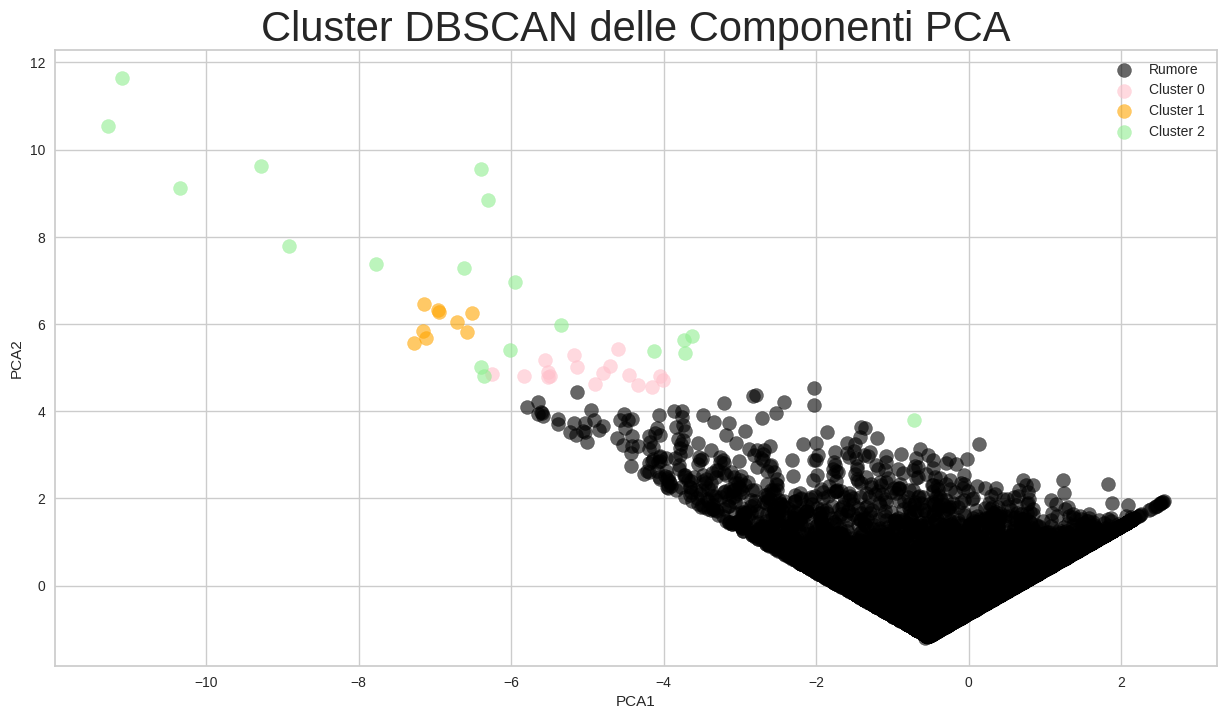

In [45]:
plt.figure(figsize=(15,8))
plt.title('Cluster DBSCAN delle Componenti PCA', fontsize=30)
unique_labels = set(y_means_dbscan)
colors_dbscan = ['black', 'pink', 'orange', 'lightgreen', 'blue', 'gray', 'red']
labels_dbscan = ['Rumore'] + [f'Cluster {i}' for i in range(n_clusters_dbscan)]
for k, col, lab in zip(unique_labels, colors_dbscan, labels_dbscan):
    plt.scatter(pca_x[y_means_dbscan == k, 0], pca_x[y_means_dbscan == k, 1],
                s=100, c=col, label=lab, alpha=0.6)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()